In [3]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ddm
from itertools import product
from IPython.display import display
from copy import copy
from itertools import product
import matplotlib.gridspec as gridspec

## Load Data

In [4]:
columns =['LAB', 'Noise Color', 'Trial', 'Noise Trial', 'Session', 'Coherence', 'Correct Response', 'Reaction Time']
data = pd.read_csv('../data/allData.txt', header = None, names=columns)

# Split LAB into Date and Lab Number
data['Date'] = [sub.split('_')[3] for sub in data['LAB']]
data['LAB'] = [sub.split('_')[2][-6:] for sub in data['LAB']]

# Select only Stimulation Trials
data = data[(data['Noise Color']=='white') | (data['Noise Color']=='pink') | (data['Noise Color']=='blue')]

# Get Subject IDs
idswitches = [True]+[True if data.iloc[n, 0] != data.iloc[n-1,0] else False for n in range(1,len(data))]
ids = [f'Sub{n:02d}' for n in np.cumsum(idswitches)]
data.insert(loc=0, column='ID', value=ids)
data = data.drop(columns='LAB')

# Get of Subject Numbers
SubjectList = np.unique(data['ID'])

# Clean from Invalid Reaction Times 
data=data.loc[~data['Reaction Time'].isnull() & data['Reaction Time']>0.1]

# bin Coherence to Percentages
data['Coherence'] = np.floor(data['Coherence']/10)
data['Coherence'] /= 100

## Plot Reaction Times and Coherence Differences over Trials
### White Noise - Sub01

Text(0.5, 1.0, 'Single Subject Reaction Times and Coherence Difference over Trials')

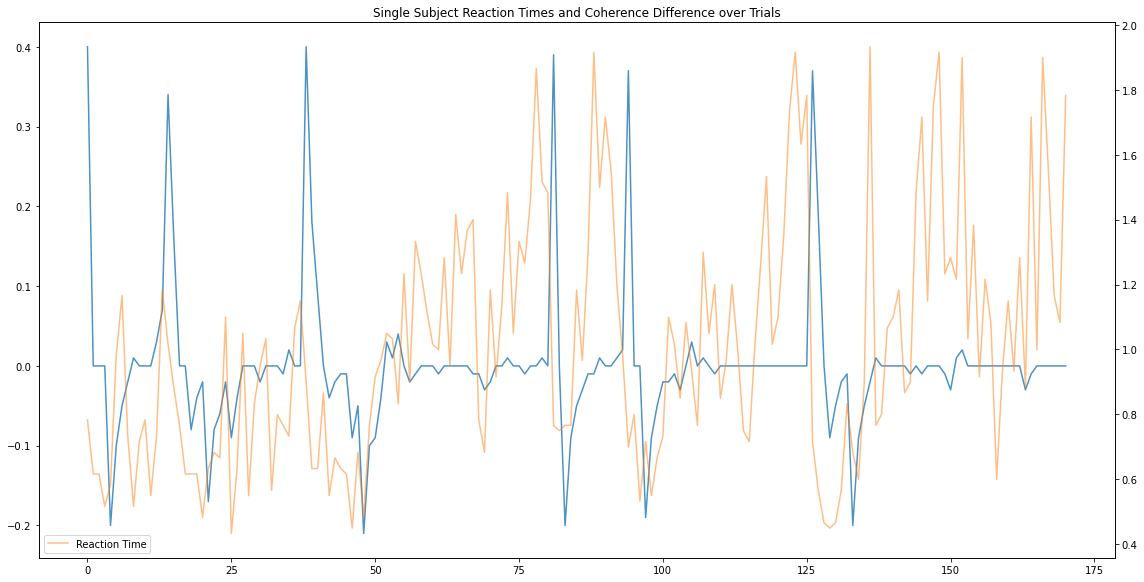

In [5]:
white = data[(data['Noise Color'] == 'white') & (data['ID']=='Sub01') & (data['Correct Response']==1)]
rt = white['Reaction Time'].to_numpy()
trials = np.arange(len(rt))

diff_coh = np.diff(white['Coherence'], prepend=0)
reset = diff_coh>=200
reset_trials = trials[reset]
min_reset_inter = 10
false_reset = [n+1 for n, reset_diff in enumerate(np.diff(reset_trials)) if reset_diff <= min_reset_inter]
reset_trials = np.delete(reset_trials, false_reset)

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(diff_coh, alpha=0.8)
for trial in reset_trials:
    ax.text(s=str(trial), x=trial-5, y=410)

# Plot Reaction Times
ax2 = ax.twinx() 
ax2.plot(trials, rt, color='tab:orange', alpha=0.5, label = 'Reaction Time')
ax2.legend(loc='lower left')
fig.tight_layout()
ax.set_title('Single Subject Reaction Times and Coherence Difference over Trials')

## Test Threshold Detection
Set WindowSize and Perf_Acc to vary the criteria of the Threshold

In [6]:
windowsize = 4
perf_acc = 3

noisecolors=['white', 'blue', 'pink']
plotcolors = ['white', 'tab:blue', 'tab:pink']
threshold = []
for color, sub in product(noisecolors, np.unique(data['ID'])):
    color_df = data[(data['Noise Color'] == color) & (data['ID']==sub)]
    
    # Get Accuracy Dataframe
    acc_dict = {'Coherence':[], 'Accuracy':[]}
    for c in np.unique(color_df['Coherence']): 
        acc = np.mean(color_df.loc[color_df['Coherence']==c, 'Correct Response'])
        acc_dict['Coherence'].append(c)
        acc_dict['Accuracy'].append(acc)
    acc_df = pd.DataFrame(acc_dict)

    # Get Coherency Threshold 
    perf_idx = np.arange(len(acc_df))[acc_df['Accuracy']==1]
    for idx in perf_idx:
        window = acc_df.iloc[idx:idx+windowsize, 1]
        if np.sum(window==1)>=perf_acc:
            thresh_idx = idx-1
            thresh = acc_df.iloc[thresh_idx,0]
            break
    threshold.append([sub, color, thresh])
thresh_df = pd.DataFrame(threshold, columns=['ID', 'Color', 'Threshold'])

### Plot Thresholds

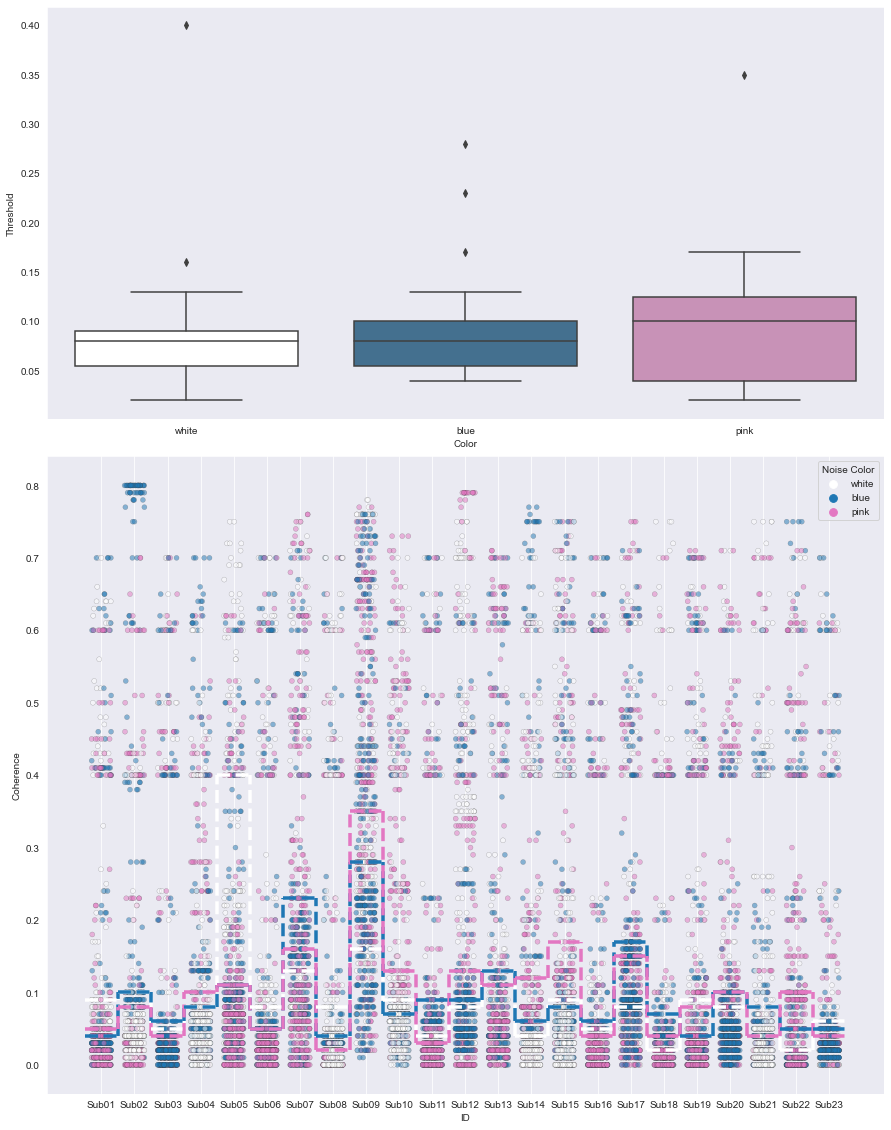

In [7]:
sns.set_style('dark')
# Plot Data and thresholds
fig = plt.figure(figsize=(15,20))
spec = gridspec.GridSpec(ncols=1, nrows=5, figure=fig)
ax = [fig.add_subplot(spec[:2, 0]), fig.add_subplot(spec[2:, 0])]
sns.set_style('darkgrid')

sns.boxplot(data=thresh_df, x='Color', y='Threshold', ax=ax[0], palette=plotcolors, saturation=0.5)
sns.stripplot(data=data, x='ID', y='Coherence', hue='Noise Color', alpha=0.5,
              edgecolor='gray', linewidth=0.3, jitter=0.3, ax=ax[1], palette=plotcolors)

for pcolor, ncolor in zip(plotcolors, noisecolors) :
    df = thresh_df[thresh_df['Color']==ncolor]
    previous_thresh = 0
    for n, thresh in enumerate(df['Threshold']):
        alpha = 1; 
        ax[1].hlines(thresh, xmin=n-0.5, xmax=n+0.5, zorder=3, linestyle='--', color=pcolor, alpha=alpha, linewidth=3.5)
        # Connect thresholds
        if n > 0:
            ymin,ymax = sorted([previous_thresh, thresh])
            ax[1].vlines(n-0.5, ymin, ymax, color=pcolor, alpha=alpha, linestyle='--', linewidth=3.5)
        previous_thresh = thresh
    ax[1].xaxis.grid(True)
    ax[1].yaxis.grid(False)

## Clean Data with Threshold
1. Exclude Sub09
2. Cut of Coherence Values above Threshold

In [8]:
data = data[data['ID']!='Sub09']
for row in thresh_df.iterrows():
    sub, color, thresh = row[1][:]
    data = data.loc[~((data['ID']==sub) & (data['Noise Color']==color) & (data['Coherence']>thresh))]

## Plot Cleaned Data
## White Noise

Text(0.5, 1.0, 'Reaction Time vs. Motion Coherence - White Noise')

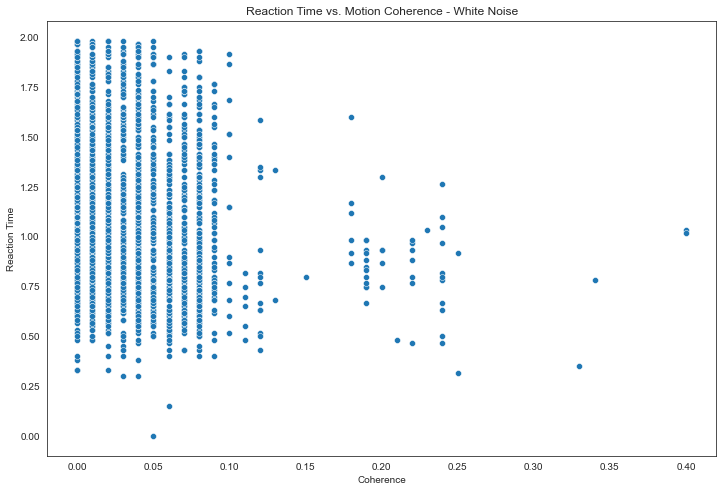

In [9]:
sns.set_style('white')
df = data[(data['Noise Color'] == 'white') & (data['Correct Response']==1)]
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(data=df, x='Coherence', y='Reaction Time', ax=ax)
ax.set_title('Reaction Time vs. Motion Coherence - White Noise')

## Plot all Noise Colors

Text(0.5, 1.0, 'Reaction Time vs. Coherence Level over Noise Colors')

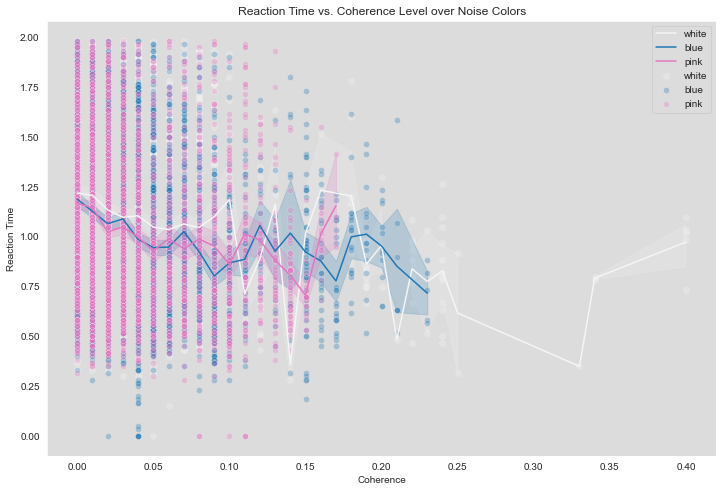

In [10]:
# Set up plot
sns.set_style('dark', {"axes.facecolor": "gainsboro"})
noisecolors=['white', 'blue', 'pink']
plotcolors = ['whitesmoke', 'tab:blue', 'tab:pink']
fig, ax = plt.subplots(figsize=(12,8))
for ncolor, pcolor in zip(noisecolors, plotcolors):
    sns.lineplot(data=data[data['Noise Color']==ncolor], x='Coherence', y='Reaction Time', ax=ax, 
                 label=ncolor, color=pcolor)
    sns.scatterplot(data=data[data['Noise Color']==ncolor], x='Coherence', y='Reaction Time', ax=ax, 
                 label=ncolor, color=pcolor, alpha=0.3)
ax.set_title('Reaction Time vs. Coherence Level over Noise Colors')

Text(0.5, 1.0, 'Reaction Time vs. Coherence Level over Noise Colors')

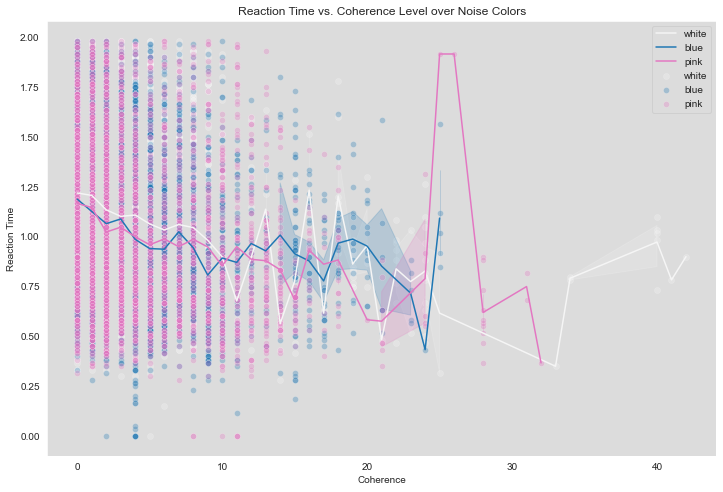

In [12]:
data = pd.read_csv('../data/CStimData.csv')
data = data.rename(columns={'coherence':'Coherence', 'rxtime':'Reaction Time', 'condition':'Noise Color'})
# Set up plot
sns.set_style('dark', {"axes.facecolor": "gainsboro"})
noisecolors=['white', 'blue', 'pink']
plotcolors = ['whitesmoke', 'tab:blue', 'tab:pink']
fig, ax = plt.subplots(figsize=(12,8))
for ncolor, pcolor in zip(noisecolors, plotcolors):
    sns.lineplot(data=data[data['Noise Color']==ncolor], x='Coherence', y='Reaction Time', ax=ax, 
                 label=ncolor, color=pcolor)
    sns.scatterplot(data=data[data['Noise Color']==ncolor], x='Coherence', y='Reaction Time', ax=ax, 
                 label=ncolor, color=pcolor, alpha=0.3)
ax.set_title('Reaction Time vs. Coherence Level over Noise Colors')